# DBiT batch RNA+ATAC panel builder (global genes across all samples)

This notebook discovers all `*_RNA.h5ad` / `*_ATAC.h5ad` pairs in a folder and builds one KaroSpace-style panel per sample using a **shared global gene list**:
- top 100 RNA genes ranked across all samples
- same 100 genes from ATAC (renamed with `ATAC_` prefix)
- total 200 features per sample with identical `var_names` across outputs
- `sample_id` and `spot_id` added to `obs`
- optional combined multi-sample output

In [17]:
from pathlib import Path
import gc

import numpy as np
import pandas as pd
import anndata as ad
from scipy import sparse

BASE_DIR = Path('/Volumes/processing2/KaroSpaceDataWrangle/dbit-data/DBiT_Di')
OUT_DIR = BASE_DIR / 'karospace_panels'

N_GENES = 200
WRITE_PER_SAMPLE = True   # Set True to write one output file per sample
WRITE_COMBINED = True     # Set True to also write one combined multi-sample file

assert BASE_DIR.exists(), f'Missing input directory: {BASE_DIR}'

In [10]:
pairs = []
missing_atac = []
for rna_path in sorted(BASE_DIR.glob('*_RNA.h5ad')):
    sample_id = rna_path.name.replace('_RNA.h5ad', '')
    atac_path = BASE_DIR / f'{sample_id}_ATAC.h5ad'
    if atac_path.exists():
        pairs.append((sample_id, rna_path, atac_path))
    else:
        missing_atac.append(sample_id)

if not pairs:
    raise ValueError(f'No RNA/ATAC pairs found in {BASE_DIR}')

print(f'Found {len(pairs)} RNA/ATAC sample pairs')
if missing_atac:
    print('Missing ATAC pairs for:', missing_atac)

pd.DataFrame(
    [{'sample_id': s, 'rna_path': str(r), 'atac_path': str(a)} for s, r, a in pairs]
).sort_values('sample_id').reset_index(drop=True)

Found 6 RNA/ATAC sample pairs


,sample_id,rna_path,atac_path
0,LPC10_S1,/Volumes/processing2/KaroSpaceDataWrangle/dbit...,/Volumes/processing2/KaroSpaceDataWrangle/dbit...
1,LPC10_S2,/Volumes/processing2/KaroSpaceDataWrangle/dbit...,/Volumes/processing2/KaroSpaceDataWrangle/dbit...
2,LPC21_S1,/Volumes/processing2/KaroSpaceDataWrangle/dbit...,/Volumes/processing2/KaroSpaceDataWrangle/dbit...
3,LPC21_S2,/Volumes/processing2/KaroSpaceDataWrangle/dbit...,/Volumes/processing2/KaroSpaceDataWrangle/dbit...
4,LPC5_S1,/Volumes/processing2/KaroSpaceDataWrangle/dbit...,/Volumes/processing2/KaroSpaceDataWrangle/dbit...
5,LPC5_S2,/Volumes/processing2/KaroSpaceDataWrangle/dbit...,/Volumes/processing2/KaroSpaceDataWrangle/dbit...


In [11]:
def _common_var_names(paths):
    common = None
    for path in paths:
        adata_b = ad.read_h5ad(path, backed='r')
        try:
            names = set(adata_b.var_names.astype(str))
        finally:
            if getattr(adata_b, 'isbacked', False):
                adata_b.file.close()
        common = names if common is None else (common & names)
    return common if common is not None else set()


def compute_global_gene_list(pairs, n_genes=100):
    rna_paths = [rna_path for _, rna_path, _ in pairs]
    atac_paths = [atac_path for _, _, atac_path in pairs]

    common_rna = _common_var_names(rna_paths)
    common_atac = _common_var_names(atac_paths)
    eligible = sorted(common_rna & common_atac)

    if len(eligible) < n_genes:
        raise ValueError(
            f'Only {len(eligible)} genes are shared across all RNA and ATAC files, requested {n_genes}.'
        )

    agg = pd.DataFrame(index=pd.Index(eligible, name='gene'))
    score_cols = []
    hvg_cols = []

    for sample_id, rna_path, _ in pairs:
        rna_b = ad.read_h5ad(rna_path, backed='r')
        try:
            var = rna_b.var.loc[eligible].copy()
        finally:
            if getattr(rna_b, 'isbacked', False):
                rna_b.file.close()

        if 'vst.variance.standardized' in var.columns:
            score = pd.to_numeric(var['vst.variance.standardized'], errors='coerce')
        elif 'highly_variable_rank' in var.columns:
            rank = pd.to_numeric(var['highly_variable_rank'], errors='coerce')
            score = -rank
        else:
            score = pd.Series(0.0, index=var.index)

        if 'vst.variable' in var.columns:
            hvg = var['vst.variable'].fillna(False).astype(bool)
        elif 'highly_variable' in var.columns:
            hvg = var['highly_variable'].fillna(False).astype(bool)
        else:
            hvg = pd.Series(True, index=var.index)

        score_col = f'{sample_id}__score'
        hvg_col = f'{sample_id}__hvg'
        agg[score_col] = score.reindex(agg.index)
        agg[hvg_col] = hvg.reindex(agg.index).fillna(False).astype(int)
        score_cols.append(score_col)
        hvg_cols.append(hvg_col)

    agg['hvg_count'] = agg[hvg_cols].sum(axis=1)
    agg['mean_score'] = agg[score_cols].mean(axis=1, skipna=True)
    agg['missing_scores'] = agg[score_cols].isna().sum(axis=1)

    ranked = agg.sort_values(
        ['hvg_count', 'mean_score', 'missing_scores'],
        ascending=[False, False, True],
    )

    selected_genes = ranked.index[:n_genes].astype(str).tolist()
    if len(selected_genes) < n_genes:
        raise ValueError(f'Unable to select {n_genes} genes globally.')

    return selected_genes, ranked.reset_index()


def build_panel_for_sample(sample_id: str, rna_path: Path, atac_path: Path, selected_genes):
    selected_genes = list(map(str, selected_genes))
    rna_b = ad.read_h5ad(rna_path, backed='r')
    atac_b = ad.read_h5ad(atac_path, backed='r')

    try:
        if rna_b.obs_names.equals(atac_b.obs_names):
            obs_names = rna_b.obs_names
        else:
            obs_names = rna_b.obs_names.intersection(atac_b.obs_names)
            if len(obs_names) == 0:
                raise ValueError(f'{sample_id}: RNA and ATAC have no shared observations')

        missing_rna = [g for g in selected_genes if g not in set(rna_b.var_names.astype(str))]
        missing_atac = [g for g in selected_genes if g not in set(atac_b.var_names.astype(str))]
        if missing_rna:
            raise ValueError(f'{sample_id}: missing selected genes in RNA: {missing_rna[:10]}')
        if missing_atac:
            raise ValueError(f'{sample_id}: missing selected genes in ATAC: {missing_atac[:10]}')

        rna_sub = rna_b[obs_names, selected_genes].to_memory()
        atac_sub = atac_b[obs_names, selected_genes].to_memory()

        if 'counts' not in rna_sub.layers:
            rna_sub.layers['counts'] = rna_sub.X.copy()
        if 'counts' not in atac_sub.layers:
            atac_sub.layers['counts'] = atac_sub.X.copy()

        rna_sub.var = rna_sub.var.copy()
        rna_sub.var['source_modality'] = 'RNA'
        rna_sub.var['paired_gene'] = rna_sub.var_names.astype(str)
        rna_sub.var['highly_variable'] = True

        atac_sub.var = atac_sub.var.copy()
        atac_sub.var['source_modality'] = 'ATAC'
        atac_sub.var['paired_gene'] = atac_sub.var_names.astype(str)
        atac_sub.var['highly_variable'] = True
        atac_sub.var_names = [f'ATAC_{g}' for g in atac_sub.var_names.astype(str)]

        obs = rna_sub.obs.copy()
        obs['sample_id'] = sample_id
        obs['spot_id'] = obs.index.astype(str)
        obs.index = [f'{sample_id}__{idx}' for idx in obs.index.astype(str)]

        X_combined = sparse.hstack([rna_sub.X, atac_sub.X], format='csr')
        var_combined = pd.concat([rna_sub.var, atac_sub.var], axis=0)

        panel = ad.AnnData(X=X_combined, obs=obs, var=var_combined)
        panel.layers['counts'] = panel.X.copy()

        if {'x', 'y'}.issubset(panel.obs.columns):
            panel.obsm['spatial'] = panel.obs[['x', 'y']].to_numpy(dtype=np.float32)

        panel.uns['panel_info'] = {
            'sample_id': sample_id,
            'source_rna': str(rna_path),
            'source_atac': str(atac_path),
            'n_rna_hvg': len(selected_genes),
            'n_atac_matched': len(selected_genes),
            'atac_feature_prefix': 'ATAC_',
            'gene_selection': 'global_across_samples',
        }

        return panel
    finally:
        if getattr(rna_b, 'isbacked', False):
            rna_b.file.close()
        if getattr(atac_b, 'isbacked', False):
            atac_b.file.close()

In [12]:
selected_genes, ranked_genes = compute_global_gene_list(pairs, n_genes=N_GENES)
print(f'Using {len(selected_genes)} global genes for all samples.')
print('Top 10 genes:', selected_genes[:10])
ranked_genes[['gene', 'hvg_count', 'mean_score']].head(20)

Using 200 global genes for all samples.
Top 10 genes: ['Rgs9', 'Rarb', 'Otx2os1', 'Tmem72', 'Gm10754', 'Sh3rf2', 'Drd2', 'Kl', 'Gmnc', 'Rbm47']


,gene,hvg_count,mean_score
0,Rgs9,6,20.146402
1,Rarb,6,18.718756
2,Otx2os1,6,17.780522
3,Tmem72,6,16.174874
4,Gm10754,6,16.070239
5,Sh3rf2,6,15.914391
6,Drd2,6,15.881085
7,Kl,6,15.047480
8,Gmnc,6,14.192311
9,Rbm47,6,13.827479


In [19]:
if WRITE_PER_SAMPLE:
    OUT_DIR.mkdir(parents=True, exist_ok=True)

summary = []
written_files = []
reference_var_names = None

for sample_id, rna_path, atac_path in pairs:
    print(f'Processing {sample_id} ...')
    panel = build_panel_for_sample(sample_id, rna_path, atac_path, selected_genes)

    if reference_var_names is None:
        reference_var_names = panel.var_names.astype(str).tolist()
    else:
        current_var_names = panel.var_names.astype(str).tolist()
        if current_var_names != reference_var_names:
            raise ValueError(f'{sample_id}: var_names differ from the first sample output.')

    out_path = OUT_DIR / f'{sample_id}_RNA{N_GENES}_plus_ATAC{N_GENES}_karospace.h5ad'
    if WRITE_PER_SAMPLE:
        panel.write_h5ad(out_path)
        written_files.append(out_path)

    summary.append(
        {
            'sample_id': sample_id,
            'n_obs': panel.n_obs,
            'n_vars': panel.n_vars,
            'n_selected_genes_global': len(selected_genes),
            'output_path': str(out_path),
        }
    )

    del panel
    gc.collect()

summary_df = pd.DataFrame(summary).sort_values('sample_id').reset_index(drop=True)
summary_df

Processing LPC10_S1 ...
Processing LPC10_S2 ...
Processing LPC21_S1 ...
Processing LPC21_S2 ...
Processing LPC5_S1 ...
Processing LPC5_S2 ...


,sample_id,n_obs,n_vars,n_selected_genes_global,output_path
0,LPC10_S1,8180,400,200,/Volumes/processing2/KaroSpaceDataWrangle/dbit...
1,LPC10_S2,8928,400,200,/Volumes/processing2/KaroSpaceDataWrangle/dbit...
2,LPC21_S1,8485,400,200,/Volumes/processing2/KaroSpaceDataWrangle/dbit...
3,LPC21_S2,8258,400,200,/Volumes/processing2/KaroSpaceDataWrangle/dbit...
4,LPC5_S1,8736,400,200,/Volumes/processing2/KaroSpaceDataWrangle/dbit...
5,LPC5_S2,8169,400,200,/Volumes/processing2/KaroSpaceDataWrangle/dbit...


In [ ]:
if WRITE_COMBINED:
    if not WRITE_PER_SAMPLE or not written_files:
        raise ValueError('WRITE_COMBINED=True requires WRITE_PER_SAMPLE=True and written sample files.')

    combined_parts = [ad.read_h5ad(path) for path in written_files]
    combined = ad.concat(combined_parts, axis=0, join='outer', merge='first', fill_value=0)
    combined.obs['sample_id'] = combined.obs['sample_id'].astype(str)

    if {'x', 'y'}.issubset(combined.obs.columns):
        combined.obsm['spatial'] = combined.obs[['x', 'y']].to_numpy(dtype=np.float32)

    combined.uns['panel_info'] = {
        'mode': 'batch_combined',
        'n_samples': len(written_files),
        'n_rna_hvg_per_sample': N_GENES,
        'n_atac_matched_per_sample': N_GENES,
        'source_dir': str(BASE_DIR),
        'gene_selection': 'global_across_samples',
    }

    combined_out = OUT_DIR / f'DBiT_all_samples_RNA{N_GENES}_plus_ATAC{N_GENES}_karospace.h5ad'
    combined.write_h5ad(combined_out)
    print(f'Wrote combined file: {combined_out}')
    print('Combined shape:', combined.shape)
else:
    print('WRITE_COMBINED is False. Set to True to write a combined multi-sample file.')

Wrote combined file: /Volumes/processing2/KaroSpaceDataWrangle/dbit-data/DBiT_Di/karospace_panels/DBiT_all_samples_RNA200_plus_ATAC200_karospace.h5ad
Combined shape: (50756, 400)


In [24]:
combined.obs['condition'] = combined.obs['sample_id'].str.split('_', expand = True)[0]

In [27]:
combined.obs

,orig.ident,nCount_RNA,nFeature_RNA,clusters,colors_map,x,y,sample_id,spot_id,condition
LPC10_S1__CTAAGGTCTTCACGCA,0,7760.575525,17044,C2,#6cfe00,983.0,881.0,LPC10_S1,CTAAGGTCTTCACGCA,LPC10
LPC10_S1__ACAGATTCGGAGAACA,0,7621.711619,16094,C2,#6cfe00,1424.0,1322.0,LPC10_S1,ACAGATTCGGAGAACA,LPC10
LPC10_S1__ACACGACCGGTGCGAA,0,7671.569407,15524,C2,#6cfe00,1392.0,1290.0,LPC10_S1,ACACGACCGGTGCGAA,LPC10
LPC10_S1__ATCATTCCGCTCGGTA,0,7746.637712,16411,C2,#6cfe00,1298.0,1353.0,LPC10_S1,ATCATTCCGCTCGGTA,LPC10
LPC10_S1__AGCACCTCGAGTTAGC,0,7517.402963,19603,C12,#60e8fc,1487.0,63.0,LPC10_S1,AGCACCTCGAGTTAGC,LPC10
...,...,...,...,...,...,...,...,...,...,...
LPC5_S2__CGCTGATCAGATGTAC,0,7075.854534,20426,C3,#e97dda,876.0,717.0,LPC5_S2,CGCTGATCAGATGTAC,LPC5
LPC5_S2__ACTATGCAATTGGCTC,0,7149.758714,20343,C15,#f5c5f0,739.0,776.0,LPC5_S2,ACTATGCAATTGGCTC,LPC5
LPC5_S2__CAGATCTGAGATGTAC,0,7256.190599,20865,C12,#60e8fc,896.0,717.0,LPC5_S2,CAGATCTGAGATGTAC,LPC5
LPC5_S2__ACCTCCAAATTGGCTC,0,6995.357979,20085,C6,#3faea2,768.0,776.0,LPC5_S2,ACCTCCAAATTGGCTC,LPC5


In [29]:
combined_out

PosixPath('/Volumes/processing2/KaroSpaceDataWrangle/dbit-data/DBiT_Di/karospace_panels/DBiT_all_samples_RNA200_plus_ATAC200_karospace.h5ad')

In [31]:
combined.var

,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized,vst.variable,source_modality,paired_gene,highly_variable
Rgs9,1.070183,0.375329,0.053431,7.024492,1,RNA,Rgs9,True
Rarb,1.259561,0.416790,0.063871,6.525498,1,RNA,Rarb,True
Otx2os1,0.580570,0.472947,0.030426,15.543983,1,RNA,Otx2os1,True
Tmem72,0.261911,0.207537,0.015617,13.289049,1,RNA,Tmem72,True
Gm10754,0.526962,0.197588,0.028215,7.003053,1,RNA,Gm10754,True
...,...,...,...,...,...,...,...,...
ATAC_Dock10,0.780012,0.004103,0.004729,0.867582,0,ATAC,Dock10,True
ATAC_Rdh5,0.610772,0.008756,0.003050,2.871130,1,ATAC,Rdh5,True
ATAC_Cmtm5,0.485875,0.018318,0.002105,8.700895,1,ATAC,Cmtm5,True
ATAC_Kcnab1,1.046315,0.008218,0.007448,1.103263,0,ATAC,Kcnab1,True


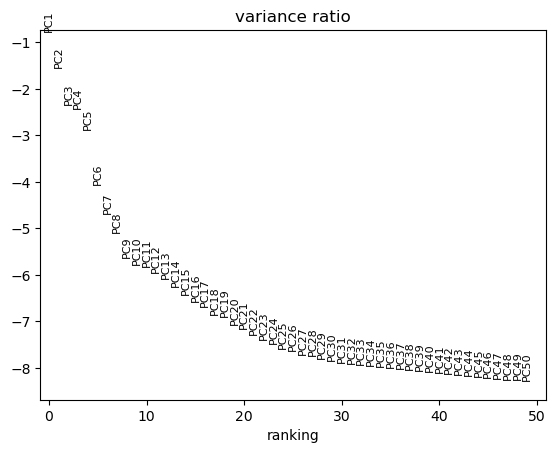

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
sc.tl.pca(combined)
sc.pl.pca_variance_ratio(combined, n_pcs=50, log=True)
sc.pp.neighbors(combined, n_neighbors=15, n_pcs=30)

In [36]:
sc.tl.umap(combined, min_dist=0.1)

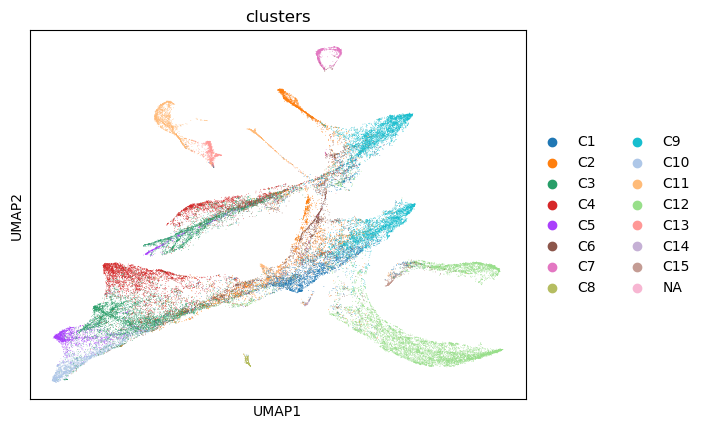

In [38]:
sc.pl.umap(combined, color=['clusters'], s=1)

In [39]:
combined.write_h5ad(combined_out)

In [43]:
combined_out

PosixPath('/Volumes/processing2/KaroSpaceDataWrangle/dbit-data/DBiT_Di/karospace_panels/DBiT_all_samples_RNA200_plus_ATAC200_karospace.h5ad')

In [44]:
combined

AnnData object with n_obs × n_vars = 50756 × 400
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'clusters', 'colors_map', 'x', 'y', 'sample_id', 'spot_id', 'condition'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'source_modality', 'paired_gene', 'highly_variable'
    uns: 'panel_info', 'pca', 'neighbors', 'umap', 'clusters_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [45]:
import anndata as ad
import squidpy as sq
import cellcharter as cc
import pandas as pd
import scanpy as sc
import scvi
import numpy as np
import matplotlib.pyplot as plt
from lightning.pytorch import seed_everything

seed_everything(12345)
scvi.settings.seed = 12345

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
Seed set to 12345
Seed set to 12345


In [ ]:
scvi.model.SCVI.setup_anndata(
    combined, 
    layer="counts", 
    batch_key='sample_id', 
)

model = scvi.model.SCVI(combined)

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [50]:
model.train(early_stopping=True, enable_progress_bar=True, max_epochs=30)

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Epoch 1/30:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 2/30:   3%|▎         | 1/30 [00:06<03:04,  6.36s/it, v_num=1, train_loss=387]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 3/30:   7%|▋         | 2/30 [00:12<02:54,  6.25s/it, v_num=1, train_loss=365]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 4/30:  10%|█         | 3/30 [00:19<02:53,  6.42s/it, v_num=1, train_loss=349]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 5/30:  13%|█▎        | 4/30 [00:25<02:47,  6.44s/it, v_num=1, train_loss=337]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 6/30:  17%|█▋        | 5/30 [00:31<02:39,  6.40s/it, v_num=1, train_loss=328]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 7/30:  20%|██        | 6/30 [00:38<02:33,  6.41s/it, v_num=1, train_loss=321]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 8/30:  23%|██▎       | 7/30 [00:44<02:26,  6.37s/it, v_num=1, train_loss=316]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 9/30:  27%|██▋       | 8/30 [00:50<02:19,  6.32s/it, v_num=1, train_loss=311]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 10/30:  30%|███       | 9/30 [00:57<02:13,  6.35s/it, v_num=1, train_loss=308]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 11/30:  33%|███▎      | 10/30 [01:03<02:06,  6.33s/it, v_num=1, train_loss=305]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 12/30:  37%|███▋      | 11/30 [01:09<02:00,  6.32s/it, v_num=1, train_loss=302]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 13/30:  40%|████      | 12/30 [01:16<01:53,  6.32s/it, v_num=1, train_loss=300]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 14/30:  43%|████▎     | 13/30 [01:22<01:47,  6.33s/it, v_num=1, train_loss=299]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 15/30:  47%|████▋     | 14/30 [01:29<01:42,  6.39s/it, v_num=1, train_loss=297]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 16/30:  50%|█████     | 15/30 [01:35<01:35,  6.35s/it, v_num=1, train_loss=296]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 17/30:  53%|█████▎    | 16/30 [01:41<01:28,  6.30s/it, v_num=1, train_loss=295]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 18/30:  57%|█████▋    | 17/30 [01:47<01:21,  6.23s/it, v_num=1, train_loss=295]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 19/30:  60%|██████    | 18/30 [01:53<01:13,  6.14s/it, v_num=1, train_loss=294]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 20/30:  63%|██████▎   | 19/30 [01:59<01:08,  6.22s/it, v_num=1, train_loss=293]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 21/30:  67%|██████▋   | 20/30 [02:06<01:02,  6.28s/it, v_num=1, train_loss=293]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 22/30:  70%|███████   | 21/30 [02:12<00:56,  6.24s/it, v_num=1, train_loss=292]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 23/30:  73%|███████▎  | 22/30 [02:18<00:49,  6.14s/it, v_num=1, train_loss=292]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 24/30:  77%|███████▋  | 23/30 [02:24<00:43,  6.23s/it, v_num=1, train_loss=292]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 25/30:  80%|████████  | 24/30 [02:31<00:37,  6.22s/it, v_num=1, train_loss=292]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 26/30:  83%|████████▎ | 25/30 [02:37<00:30,  6.15s/it, v_num=1, train_loss=291]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 27/30:  87%|████████▋ | 26/30 [02:42<00:24,  6.09s/it, v_num=1, train_loss=291]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 28/30:  90%|█████████ | 27/30 [02:49<00:18,  6.17s/it, v_num=1, train_loss=291]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 29/30:  93%|█████████▎| 28/30 [02:55<00:12,  6.17s/it, v_num=1, train_loss=291]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 30/30:  97%|█████████▋| 29/30 [03:01<00:06,  6.20s/it, v_num=1, train_loss=291]

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 30/30: 100%|██████████| 30/30 [03:07<00:00,  6.14s/it, v_num=1, train_loss=291]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|██████████| 30/30 [03:07<00:00,  6.26s/it, v_num=1, train_loss=291]


In [51]:
combined.obsm['X_scVI'] = model.get_latent_representation(combined).astype(np.float32)

In [54]:
sq.gr.spatial_neighbors(combined, library_key='sample_id', coord_type='generic', delaunay=True, spatial_key='spatial', percentile=99)

In [55]:
cc.gr.aggregate_neighbors(combined, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter', sample_key='sample')


Epoch 1/158:   0%|          | 0/158 [03:48<?, ?it/s]


100%|██████████| 4/4 [00:00<00:00, 29.65it/s]


In [64]:
# GMM components to try
# GMM components to try
gmm_components = [5,7]



In [65]:
from sklearn.mixture import GaussianMixture
import pandas as pd

X = combined.obsm['X_cellcharter']
gmm_results = []

for k in gmm_components:
    print(k)
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=0,
        n_init=3,
    )
    labels = gmm.fit_predict(X)
    key = f'CellCharter_{k}'
    combined.obs[key] = labels.astype(str)
    gmm_results.append({
        'k': k,
        'bic': gmm.bic(X),
        'aic': gmm.aic(X),
    })
    n_clusters = combined.obs[key].nunique()
    print(f'k={k}: {n_clusters} clusters')


5
k=5: 5 clusters
7
k=7: 7 clusters


In [66]:
import scanpy as sc

try:
    import sys
    sys.path.append('/Users/chrislangseth/work/karolinska_institutet/projects/BaloMS/')
    from utils import spatial_utils

    def plot_spatial(adata, color, groupby='sample_id', spot_size=1, cols=2, height=8, legend_col_width=1.0, **kwargs):
        return spatial_utils.plot_spatial_compact_fast(
            adata,
            color=color,
            groupby=groupby,
            spot_size=spot_size,
            cols=cols,
            height=height,
            legend_col_width=legend_col_width,
            **kwargs,
        )

except Exception as e:
    print(f'External spatial_utils not available, using Scanpy fallback: {e}')

    def plot_spatial(adata, color, groupby='sample_id', spot_size=1, **kwargs):
        if 'spatial' in adata.obsm:
            return sc.pl.embedding(adata, basis='spatial', color=color, size=spot_size, frameon=False)
        return sc.pl.umap(adata, color=color, size=spot_size)


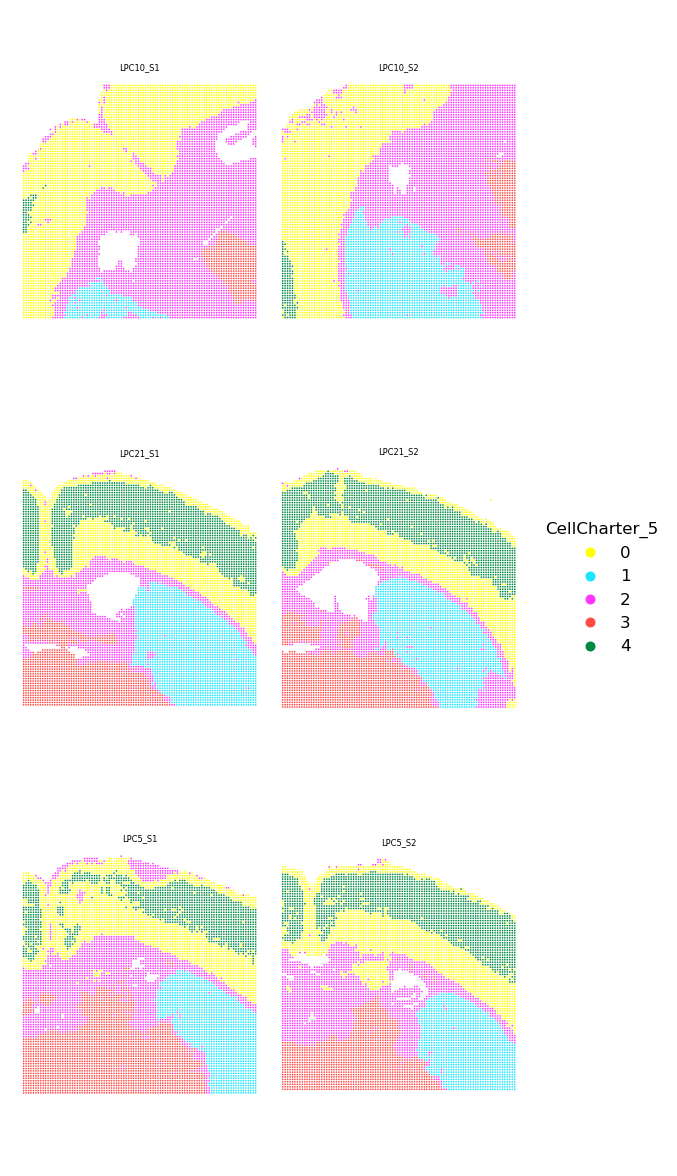

In [67]:
plot_spatial(
    combined,
    color="CellCharter_5",
    groupby="sample_id",
    spot_size=1,
    cols=2,
    height=10,
    background="white",
    dpi=120,
)


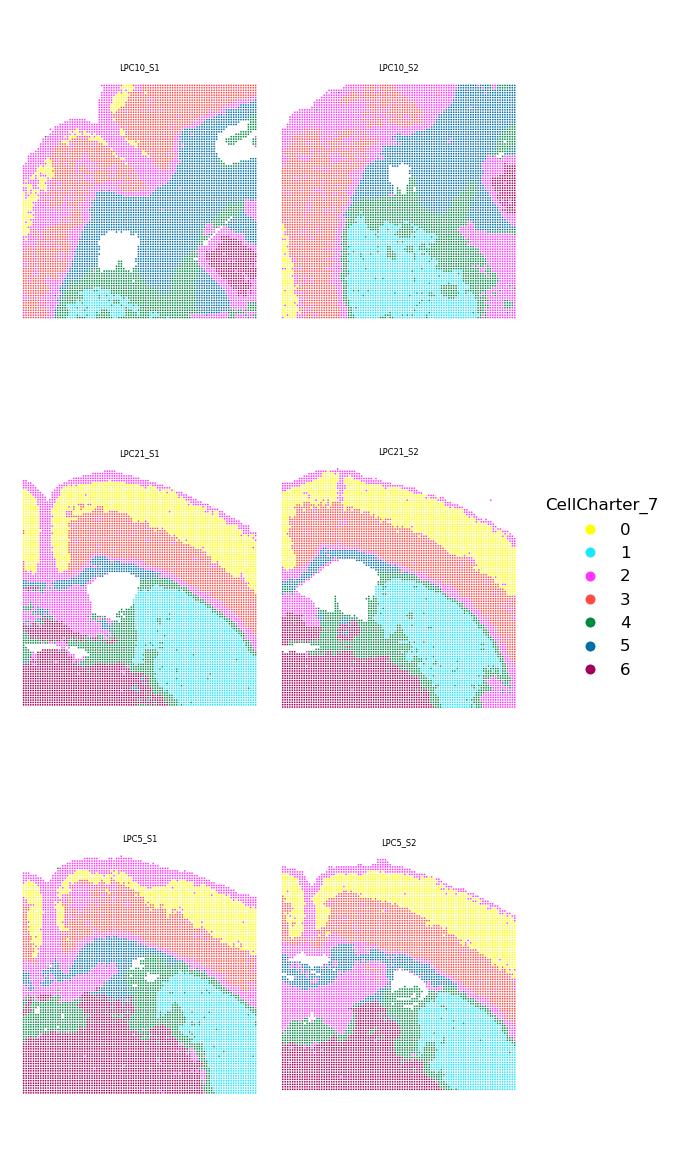

In [68]:
plot_spatial(
    combined,
    color="CellCharter_7",
    groupby="sample_id",
    spot_size=1,
    cols=2,
    height=10,
    background="white",
    dpi=120,
)


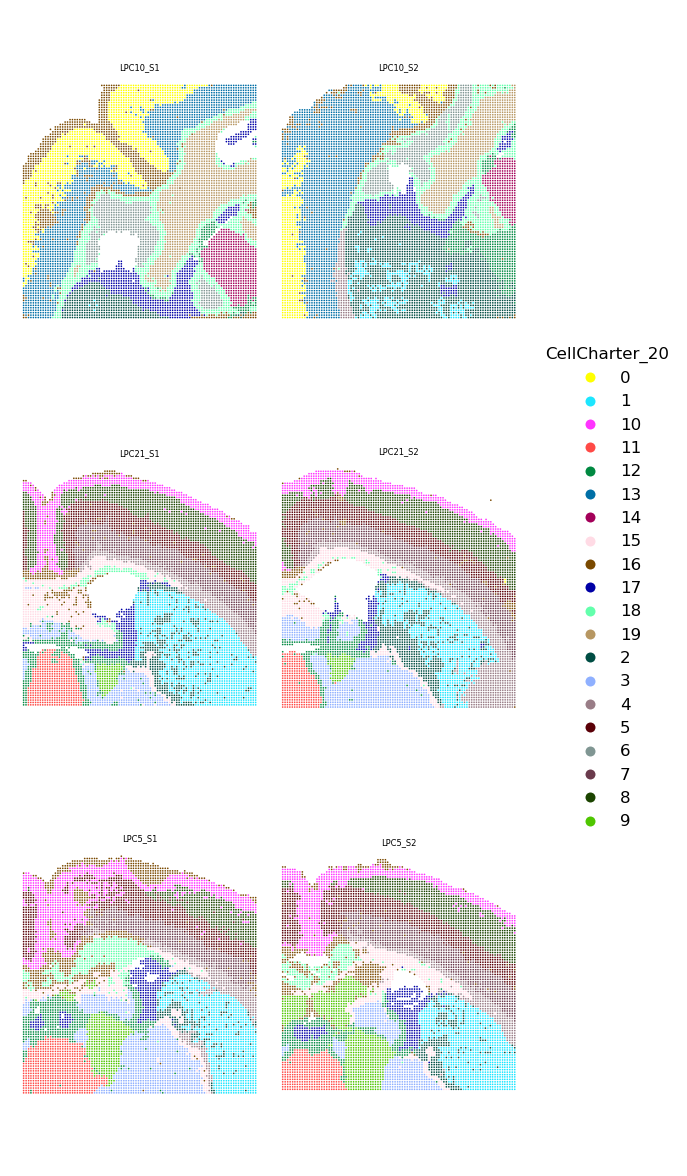

In [ ]:
plot_spatial(
    combined,
    color="CellCharter_20",
    groupby="sample_id",
    spot_size=1,
    cols=2,
    height=10,
    background="white",
    dpi=120,
)


In [ ]:
combined.write_h5ad(combined_out)